In [1]:
import seaborn as sns
import pylab as rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib 
import pandas as pd 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from  sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping
from tcn import TCN


2023-11-01 21:05:08.334432: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-01 21:05:08.354374: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-01 21:05:08.354401: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-01 21:05:08.354413: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-01 21:05:08.359442: I tensorflow/core/platform/cpu_feature_g

In [2]:
df=pd.read_csv('/home/j/usfq/tesis/StockPredictionModels/Data/Complete.csv')
df

,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.857156,27.847500,27.860001,26.837500,27.332500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.731959,15.629000,15.737500,15.348000,15.426000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.883473,26.378078,26.490770,26.133251,26.168653,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.908735,26.629999,26.790001,26.393999,26.477501,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.804051,46.660000,47.419998,46.540001,46.759998,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7531,2019-12-30,AMZN,0.748412,93.699997,94.199997,92.030998,92.344498,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7532,2019-12-30,GOOG,0.676151,67.500000,67.650002,66.700996,66.806999,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7533,2019-12-30,GOOGL,0.705876,67.840500,67.849998,66.891998,66.985497,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7534,2019-12-30,MSFT,0.762997,158.990005,159.020004,156.729996,157.589996,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


In [3]:
#turn date into unix time
#df['Date'] = pd.to_datetime(df['Date'])
#df['Date'] = df['Date'].apply(lambda x: x.timestamp())
#df

In [4]:
#generate new dataframes for each ticker_symbol
df_dict={}
for key in df['ticker_symbol'].unique():
    df_dict[key]=df[df['ticker_symbol']==key]
    df_dict[key]=df_dict[key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)
    #df_dict[key]=df_dict[key].drop(columns=['Date'])
    print(key,df_dict[key].shape)
    print(df_dict[key].head(-1))

AAPL (1252, 17)
            Date  p_sentiment       Open       High        Low      Close  \
0     2015-01-02     0.857156  27.847500  27.860001  26.837500  27.332500   
1     2015-01-05     0.744531  27.072500  27.162500  26.352501  26.562500   
2     2015-01-06     0.769826  26.635000  26.857500  26.157499  26.565001   
3     2015-01-07     0.773995  26.799999  27.049999  26.674999  26.937500   
4     2015-01-08     0.770458  27.307501  28.037500  27.174999  27.972500   
...          ...          ...        ...        ...        ...        ...   
1246  2019-12-20     0.775477  70.557503  70.662498  69.639999  69.860001   
1247  2019-12-23     0.759453  70.132500  71.062500  70.092499  71.000000   
1248  2019-12-24     0.742264  71.172501  71.222504  70.730003  71.067497   
1249  2019-12-26     0.670220  71.205002  72.495003  71.175003  72.477501   
1250  2019-12-27     0.760582  72.779999  73.492500  72.029999  72.449997   

      unrate  psr       m2    dspic      pce    reer       

In [5]:
ticker='TSLA'

In [6]:
df=df_dict[ticker].copy()
df.head()

,Date,p_sentiment,Open,High,Low,Close,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,0.741818,14.858000,14.883333,14.217333,14.620667,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
1,2015-01-05,0.646626,14.303333,14.433333,13.810667,14.006000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
2,2015-01-06,0.696584,14.004000,14.280000,13.614000,14.085333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
3,2015-01-07,0.654833,14.223333,14.318667,13.985333,14.063333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
4,2015-01-08,0.615611,14.187333,14.253333,14.000667,14.041333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811


In [7]:
#putting the close column on the last position
df=df[['Date',
'p_sentiment',
 'Open',
 'High',
 'Low',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
  'Close',]]

In [8]:
dates = pd.to_datetime(df['Date'])

In [9]:
cols=list(df)[1:]
cols

['p_sentiment',
 'Open',
 'High',
 'Low',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
 'Close']

In [10]:
df_for_training = df[cols].astype(float)

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_for_training)

In [12]:
print(scaled_data)

[[0.78512475 0.27521525 0.24356139 ... 0.77924797 0.         0.26330631]
 [0.57178167 0.24678828 0.21948349 ... 0.77924797 0.         0.23121105]
 [0.68374619 0.23144731 0.21127918 ... 0.77924797 0.         0.23535347]
 ...
 [0.47142104 0.97577552 0.99347221 ... 0.57323507 1.         1.        ]
 [0.38496901 1.         1.         ... 0.57323507 1.         0.99805053]
 [0.44112774 0.97878229 0.97749165 ... 0.57323507 1.         0.9434678 ]]


In [13]:
#split scaled data into training, val and testing
#train_data=scaled_data[0:1000,:]
#val_data=scaled_data[1000:1125,:]
#test_data=scaled_data[1125:,:]

In [14]:
n_future = 1 # Number of days we want to predict into the future
n_past = 7 # Number of past days we want to use to predict the future

In [15]:
X=[]
y=[]
for i in range(n_past, len(scaled_data) - n_future +1):
    X.append(scaled_data[i - n_past:i, 0:df_for_training.shape[1]])
    y.append(scaled_data[i + n_future - 1:i + n_future, len(cols)-1])

In [16]:
#shape of X_s and y_s
X, y = np.array(X), np.array(y)
print(X.shape)
print(y.shape)

(1250, 7, 16)
(1250, 1)


In [17]:
X_train=X[0:1220,:]
X_test=X[1220:,:]
y_train=y[0:1220,:]
y_test=y[1220:,:]

#early stopping

2023-11-01 21:05:09.535934: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-01 21:05:09.574346: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-01 21:05:09.574693: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-01 21:05:09.578601: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-01 21:05:09.578804: I tensorflow/compile

Epoch 1/1000


2023-11-01 21:05:11.126586: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2023-11-01 21:05:11.273228: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-01 21:05:11.624672: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-01 21:05:12.047981: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ef9ed9b14c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-01 21:05:12.048008: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2023-11-01 21:05:12.058373: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-01 21:05:12.148236: I ./tensorflow/compiler/jit/device_c

4/4 [==============================] - 4s 189ms/step - loss: 18.4439 - val_loss: 7.6305
Epoch 2/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.8076 - val_loss: 0.0694
Epoch 3/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.7463 - val_loss: 0.3861
Epoch 4/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1867 - val_loss: 0.3289
Epoch 5/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1863 - val_loss: 0.0210
Epoch 6/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0886 - val_loss: 0.0732
Epoch 7/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0316 - val_loss: 0.0332
Epoch 8/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0464 - val_loss: 0.0158
Epoch 9/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.0082 - val_loss: 0.0260
Epoch 10/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0208 - val_loss: 0.0043
Epoch 11/1000
4/4 [=

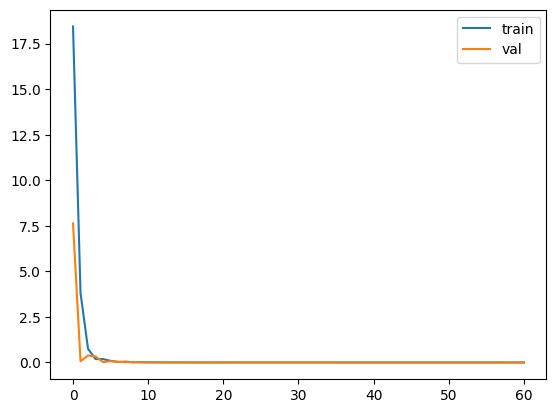

1/1 [==============================] - 0s 179ms/step
mae: 13.405516102067057
(30,)
(30,)


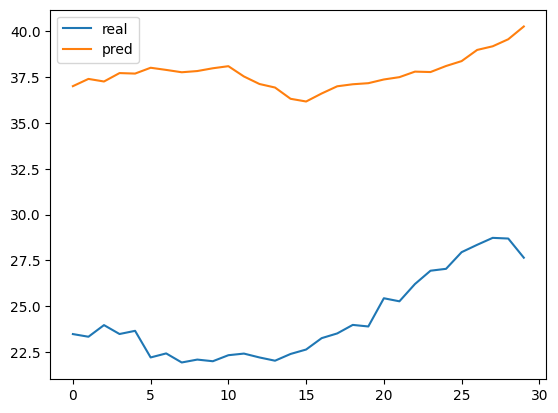

Epoch 1/1000
8/8 [==============================] - 2s 83ms/step - loss: 9.9640 - val_loss: 0.8519
Epoch 2/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.5937 - val_loss: 0.3613
Epoch 3/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.8580 - val_loss: 0.4609
Epoch 4/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0479 - val_loss: 0.0268
Epoch 5/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0376 - val_loss: 0.0418
Epoch 6/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0192 - val_loss: 0.0082
Epoch 7/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0072 - val_loss: 0.0074
Epoch 8/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 9/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0029 - val_loss: 0.0039
Epoch 10/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0019 - val_loss: 0.0031
Epoch 11/1000
8/8

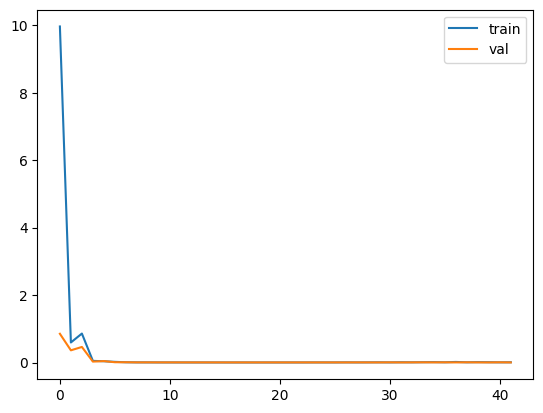

1/1 [==============================] - 0s 114ms/step
mae: 3.400592917354331
(30,)
(30,)


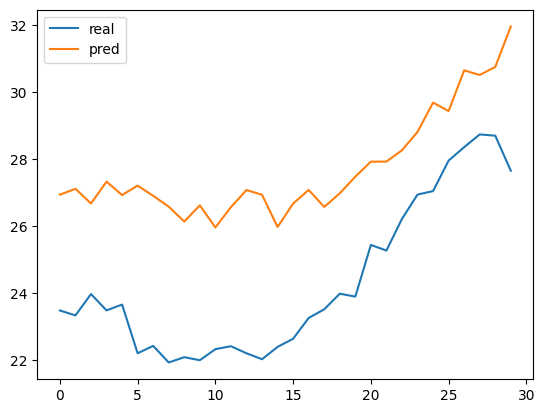

Epoch 1/1000
11/11 [==============================] - 2s 57ms/step - loss: 9.9162 - val_loss: 0.0862
Epoch 2/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.4291 - val_loss: 0.4648
Epoch 3/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.9619 - val_loss: 0.1659
Epoch 4/1000
11/11 [==============================] - 0s 8ms/step - loss: 1.0792 - val_loss: 0.5221
Epoch 5/1000
11/11 [==============================] - 0s 8ms/step - loss: 1.5895 - val_loss: 0.4601
Epoch 6/1000
11/11 [==============================] - 0s 9ms/step - loss: 0.1346 - val_loss: 0.0927
Epoch 7/1000
11/11 [==============================] - 0s 9ms/step - loss: 0.0609 - val_loss: 0.0138
Epoch 8/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0210 - val_loss: 0.0055
Epoch 9/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0040 - val_loss: 0.0071
Epoch 10/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0016 - val_loss: 0.004

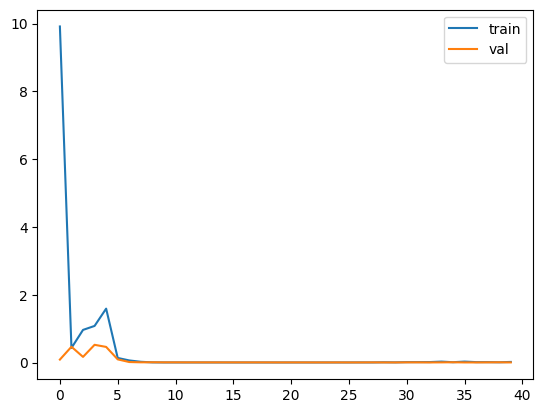

1/1 [==============================] - 0s 115ms/step
mae: 3.46539060061035
(30,)
(30,)


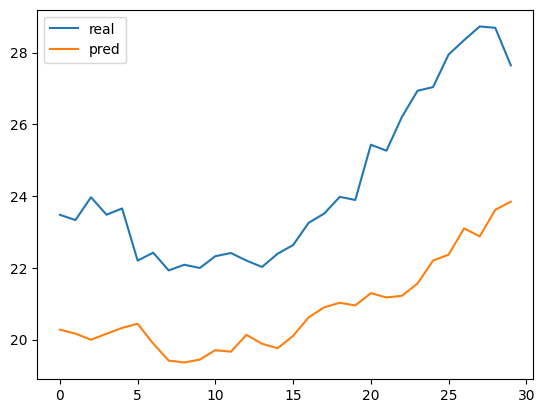

Epoch 1/1000
15/15 [==============================] - 2s 36ms/step - loss: 6.7224 - val_loss: 0.1325
Epoch 2/1000
15/15 [==============================] - 0s 7ms/step - loss: 0.4754 - val_loss: 0.1042
Epoch 3/1000
15/15 [==============================] - 0s 7ms/step - loss: 0.4448 - val_loss: 0.1508
Epoch 4/1000
15/15 [==============================] - 0s 7ms/step - loss: 0.0807 - val_loss: 0.1364
Epoch 5/1000
15/15 [==============================] - 0s 7ms/step - loss: 0.1573 - val_loss: 0.1798
Epoch 6/1000
15/15 [==============================] - 0s 7ms/step - loss: 0.4307 - val_loss: 0.2659
Epoch 7/1000
15/15 [==============================] - 0s 8ms/step - loss: 0.1876 - val_loss: 0.0657
Epoch 8/1000
15/15 [==============================] - 0s 8ms/step - loss: 0.4220 - val_loss: 0.0074
Epoch 9/1000
15/15 [==============================] - 0s 8ms/step - loss: 0.0473 - val_loss: 0.0386
Epoch 10/1000
15/15 [==============================] - 0s 8ms/step - loss: 0.0899 - val_loss: 0.007

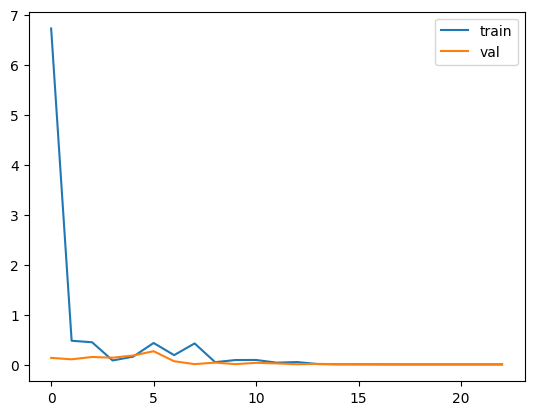

1/1 [==============================] - 0s 111ms/step
mae: 7.260653827437338
(30,)
(30,)


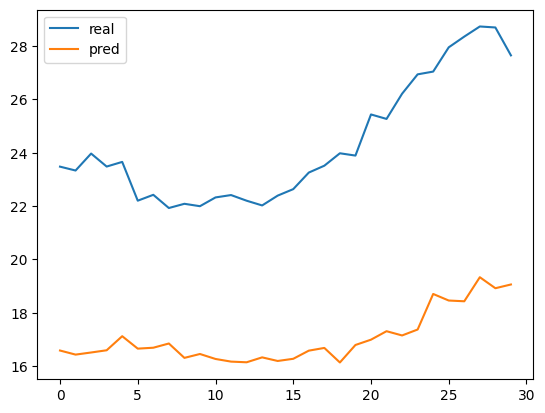

Epoch 1/1000
18/18 [==============================] - 2s 35ms/step - loss: 3.9302 - val_loss: 0.1215
Epoch 2/1000
18/18 [==============================] - 0s 7ms/step - loss: 0.2802 - val_loss: 1.4892
Epoch 3/1000
18/18 [==============================] - 0s 7ms/step - loss: 0.8423 - val_loss: 0.0043
Epoch 4/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.1488 - val_loss: 0.1410
Epoch 5/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.0691 - val_loss: 0.0131
Epoch 6/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.0992 - val_loss: 0.1394
Epoch 7/1000
18/18 [==============================] - 0s 9ms/step - loss: 0.1513 - val_loss: 0.0302
Epoch 8/1000
18/18 [==============================] - 0s 7ms/step - loss: 0.0581 - val_loss: 0.0843
Epoch 9/1000
18/18 [==============================] - 0s 7ms/step - loss: 0.0646 - val_loss: 0.2854
Epoch 10/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.0778 - val_loss: 0.003

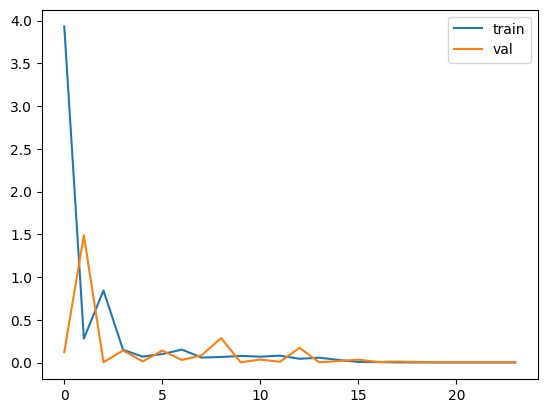

1/1 [==============================] - 0s 109ms/step
mae: 1.719638187711588
(30,)
(30,)


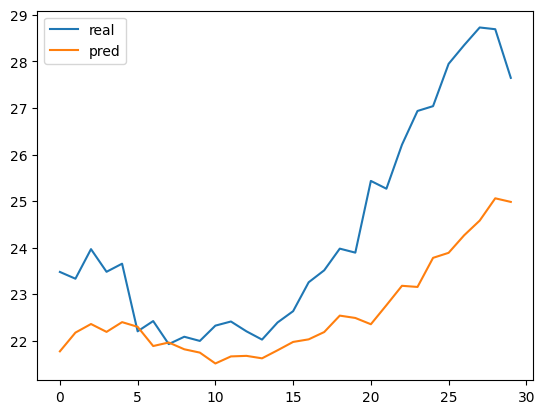

Epoch 1/1000
21/21 [==============================] - 2s 33ms/step - loss: 6.0300 - val_loss: 0.0273
Epoch 2/1000
21/21 [==============================] - 0s 7ms/step - loss: 0.5446 - val_loss: 0.9732
Epoch 3/1000
21/21 [==============================] - 0s 7ms/step - loss: 0.4978 - val_loss: 0.0181
Epoch 4/1000
21/21 [==============================] - 0s 7ms/step - loss: 0.8376 - val_loss: 0.0560
Epoch 5/1000
21/21 [==============================] - 0s 8ms/step - loss: 0.0370 - val_loss: 0.0132
Epoch 6/1000
21/21 [==============================] - 0s 7ms/step - loss: 0.1322 - val_loss: 0.0638
Epoch 7/1000
21/21 [==============================] - 0s 7ms/step - loss: 0.1960 - val_loss: 0.0025
Epoch 8/1000
21/21 [==============================] - 0s 6ms/step - loss: 0.1019 - val_loss: 0.0090
Epoch 9/1000
21/21 [==============================] - 0s 7ms/step - loss: 0.1097 - val_loss: 0.0219
Epoch 10/1000
21/21 [==============================] - 0s 7ms/step - loss: 0.2831 - val_loss: 0.055

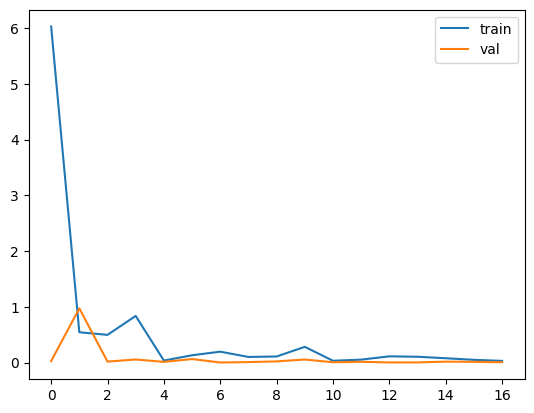

1/1 [==============================] - 0s 116ms/step
mae: 1.1306216257609045
(30,)
(30,)


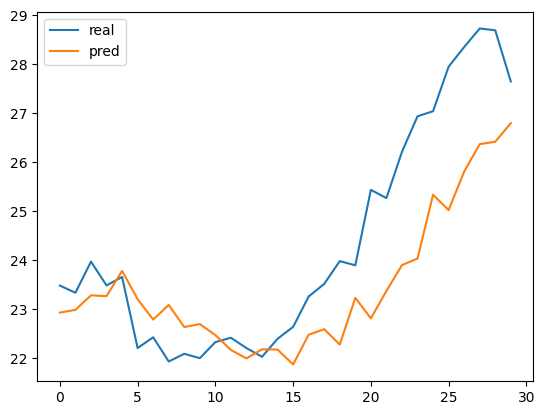

Epoch 1/1000
25/25 [==============================] - 2s 21ms/step - loss: 5.4223 - val_loss: 0.3158
Epoch 2/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.1486 - val_loss: 0.0233
Epoch 3/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.5136 - val_loss: 0.0691
Epoch 4/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.3181 - val_loss: 0.1098
Epoch 5/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.1893 - val_loss: 0.0265
Epoch 6/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.3603 - val_loss: 0.0795
Epoch 7/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.3216 - val_loss: 0.3203
Epoch 8/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0585 - val_loss: 0.0259
Epoch 9/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0243 - val_loss: 0.0165
Epoch 10/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.1341 - val_loss: 0.004

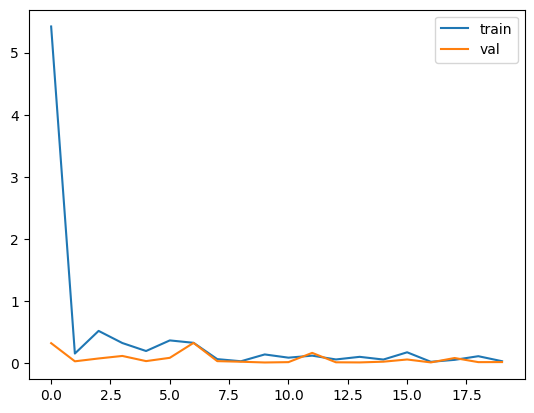

1/1 [==============================] - 0s 111ms/step
mae: 4.077433091251626
(30,)
(30,)


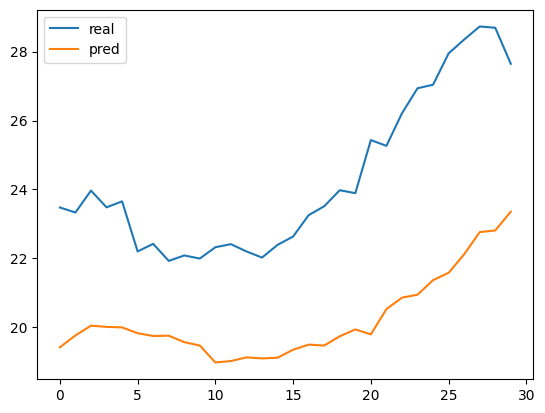

Epoch 1/1000
28/28 [==============================] - 3s 26ms/step - loss: 3.7250 - val_loss: 0.1048
Epoch 2/1000
28/28 [==============================] - 0s 7ms/step - loss: 0.3073 - val_loss: 0.1029
Epoch 3/1000
28/28 [==============================] - 0s 7ms/step - loss: 0.3331 - val_loss: 0.4197
Epoch 4/1000
28/28 [==============================] - 0s 7ms/step - loss: 0.1569 - val_loss: 0.0240
Epoch 5/1000
28/28 [==============================] - 0s 7ms/step - loss: 0.2440 - val_loss: 0.0220
Epoch 6/1000
28/28 [==============================] - 0s 7ms/step - loss: 0.0189 - val_loss: 0.1204
Epoch 7/1000
28/28 [==============================] - 0s 7ms/step - loss: 0.0543 - val_loss: 0.1626
Epoch 8/1000
28/28 [==============================] - 0s 6ms/step - loss: 0.1351 - val_loss: 0.0534
Epoch 9/1000
28/28 [==============================] - 0s 7ms/step - loss: 0.1798 - val_loss: 0.0444
Epoch 10/1000
28/28 [==============================] - 0s 6ms/step - loss: 0.1060 - val_loss: 0.104

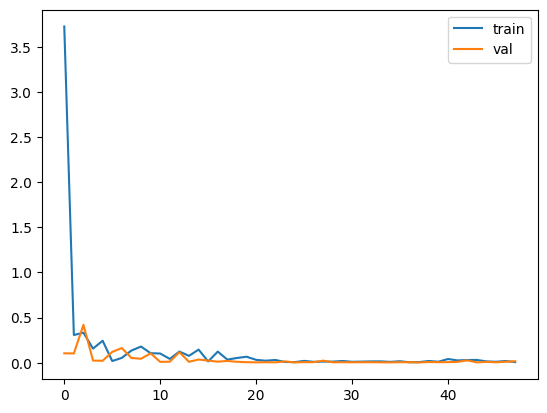

1/1 [==============================] - 0s 110ms/step
mae: 5.235913326493327
(30,)
(30,)


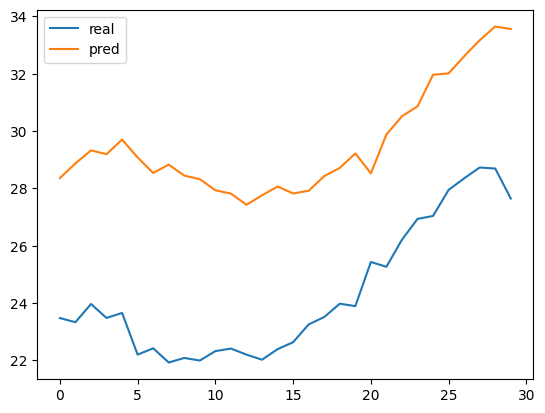

Epoch 1/1000
32/32 [==============================] - 2s 20ms/step - loss: 3.7041 - val_loss: 0.0770
Epoch 2/1000
32/32 [==============================] - 0s 7ms/step - loss: 0.2264 - val_loss: 0.2376
Epoch 3/1000
32/32 [==============================] - 0s 7ms/step - loss: 0.1380 - val_loss: 0.1912
Epoch 4/1000
32/32 [==============================] - 0s 7ms/step - loss: 0.2780 - val_loss: 0.2953
Epoch 5/1000
32/32 [==============================] - 0s 6ms/step - loss: 0.1582 - val_loss: 0.0173
Epoch 6/1000
32/32 [==============================] - 0s 7ms/step - loss: 0.2138 - val_loss: 0.1669
Epoch 7/1000
32/32 [==============================] - 0s 8ms/step - loss: 0.1109 - val_loss: 0.0113
Epoch 8/1000
32/32 [==============================] - 0s 7ms/step - loss: 0.0427 - val_loss: 0.0176
Epoch 9/1000
32/32 [==============================] - 0s 6ms/step - loss: 0.0332 - val_loss: 0.0091
Epoch 10/1000
32/32 [==============================] - 0s 7ms/step - loss: 0.0776 - val_loss: 0.079

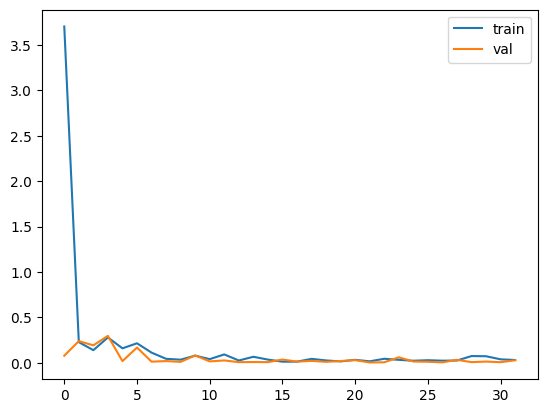

1/1 [==============================] - 0s 117ms/step
mae: 2.8115130604817713
(30,)
(30,)


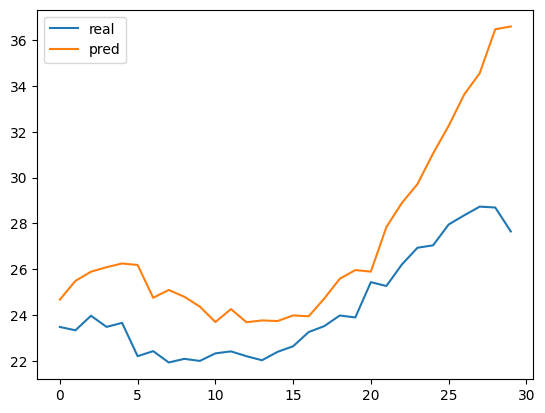

Epoch 1/1000
35/35 [==============================] - 2s 21ms/step - loss: 3.3773 - val_loss: 0.0076
Epoch 2/1000
35/35 [==============================] - 0s 7ms/step - loss: 0.1350 - val_loss: 0.2058
Epoch 3/1000
35/35 [==============================] - 0s 7ms/step - loss: 0.1292 - val_loss: 0.3493
Epoch 4/1000
35/35 [==============================] - 0s 7ms/step - loss: 0.4821 - val_loss: 0.1192
Epoch 5/1000
35/35 [==============================] - 0s 6ms/step - loss: 0.1868 - val_loss: 0.0117
Epoch 6/1000
35/35 [==============================] - 0s 6ms/step - loss: 0.1080 - val_loss: 0.0239
Epoch 7/1000
35/35 [==============================] - 0s 6ms/step - loss: 0.0678 - val_loss: 0.0107
Epoch 8/1000
35/35 [==============================] - 0s 6ms/step - loss: 0.0250 - val_loss: 0.0235
Epoch 9/1000
35/35 [==============================] - 0s 7ms/step - loss: 0.0114 - val_loss: 0.0051
Epoch 10/1000
35/35 [==============================] - 0s 6ms/step - loss: 0.0178 - val_loss: 0.003

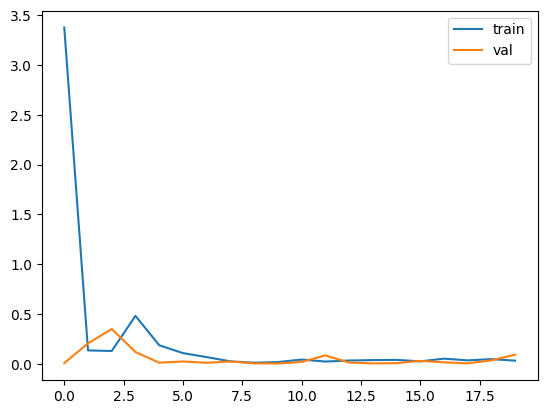

1/1 [==============================] - 0s 111ms/step
mae: 13.122642948380534
(30,)
(30,)


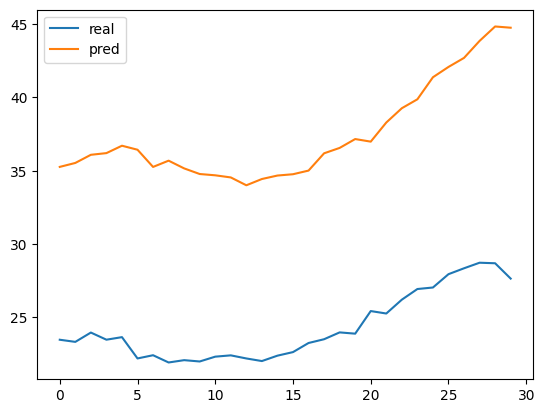

In [18]:
tscv = TimeSeriesSplit(n_splits=10)
y_test=np.repeat(y_test,16,axis=1)
y_test=scaler.inverse_transform(y_test)[:,-1] 
for train_index, val_index in tscv.split(X_train):
    early_stop=EarlyStopping(monitor='val_loss',patience=10)
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model=Sequential()
    model.add(
     TCN(
         input_shape=(X_train.shape[1], X_train.shape[2]),
         kernel_size=5,
         dilations=[1, 2, 4, 8, 16],
         return_sequences=False,
        activation='relu',
            nb_filters=256,
         padding='causal',
         #dropout_rate=0.25,
         kernel_initializer='he_normal',
     )   
    )
    model.add(Dense(y_train.shape[1]))
    model.compile(optimizer='adam',loss='mse')
  
    history=model.fit(X_train,y_train,epochs=1000,validation_data=(X_val,y_val),shuffle=False, callbacks=[early_stop])
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='val')
    plt.legend()
    plt.show()
    y_pred=model.predict(X_test)
    y_pred.shape
    #accuracy and other metrics
    pred=np.repeat(y_pred,16,axis=1)

    pred=scaler.inverse_transform(pred)[:,-1]
    
    #print mae for pred and y_test
    print('mae:',np.mean(np.abs(pred-y_test)))

    print(pred.shape)
    print(y_test.shape)

    #plotting the results
    plt.plot(y_test, label='real')
    plt.plot(pred, label='pred') 
    plt.legend()
    plt.show()
